In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import requests
import io
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from datetime import datetime
import warnings

In [ ]:
def load_file_json(path, nrows=None):
    samples = []
    rf = open(path, 'r', encoding='utf-8')
    for idx, line in tqdm(enumerate(rf)):
        if nrows and idx == nrows:
            break
        samples.append(json.loads(line))
    rf.close()
    return pd.DataFrame(samples)

In [ ]:
def check_na(data):
  data.replace('', np.nan, inplace=True)
  return data.isna().sum()

In [ ]:
RAW_DATA_DIR = '/content/drive/MyDrive/Nhom12/Data/raw'
PRE_DATA_DIR = '/content/drive/MyDrive/Nhom12/Data/data_prepared'

# **course**

In [ ]:
course_df = load_file_json('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/entities/course.json')
course_df.head()

3781it [00:11, 331.15it/s] 


,id,name,field,prerequisites,about,resource
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':..."
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res..."
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide..."
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],..."


In [ ]:
course_df.describe()

,id,name,field,prerequisites,about,resource
count,3781,3781,3781,3779,3779,3781
unique,3781,3240,147,793,3227,3781
top,C_584313,线性代数,[],,高校教师教学&科研能力提升全周期培养计划,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
freq,1,9,3234,2578,68,1


In [ ]:
check_na(course_df)

,0
id,0
name,0
field,0
prerequisites,2580
about,65
resource,0


In [ ]:
course_filtered = course_df.dropna(subset=['about'])

In [ ]:
course_filtered_backup = course_filtered.copy()

## thông kê và bổ sung trường field

Trường field của course trong file course.json rỗng rất nhiều. Thông tin về field của course còn có trong file course-field.json, nên nhóm sẽ sử dụng file này để bổ sung

In [ ]:
course_field_df = load_file_json('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/relations/course-field.json')
course_field_df

632it [00:00, 52777.45it/s]


,course_id,course_name,field
0,584313,《资治通鉴》导读,"[中国语言文学, 历史学]"
1,681932,“做中学”Java程序设计,[计算机科学与技术]
2,674962,《红楼梦》的空间艺术,[中国语言文学]
3,682709,《纯粹理性批判》导论,[哲学]
4,682635,《统万城》导读,[历史学]
...,...,...,...
627,677102,走进性科学,[教育学]
628,677118,走近中华优秀传统文化,[社会学]
629,682442,组合数学,[数学]
630,697427,足球运动与科学,[体育学]


In [ ]:
course_field_df.describe()

,course_id
count,6.320000e+02
mean,6.911180e+05
std,8.401928e+04
min,5.843130e+05
25%,6.807290e+05
50%,6.817855e+05
75%,6.966760e+05
max,1.814513e+06


In [ ]:
course_field_df['course_id'] = course_field_df['course_id'].apply(lambda x: f'C_{x}')

Để đảm bảo tính nhất quán, ta sẽ lọc bỏ những khóa học
của file course-field.json mà không tồn tại trong course.json.

In [ ]:
course_ids = set(course_filtered['id'])
course_field_df = course_field_df[course_field_df['course_id'].isin(course_ids)]

In [ ]:
course_field_df

,course_id,course_name,field
0,C_584313,《资治通鉴》导读,"[中国语言文学, 历史学]"
1,C_681932,“做中学”Java程序设计,[计算机科学与技术]
2,C_674962,《红楼梦》的空间艺术,[中国语言文学]
3,C_682709,《纯粹理性批判》导论,[哲学]
5,C_629515,《论语》人生课堂,[中国语言文学]
...,...,...,...
627,C_677102,走进性科学,[教育学]
628,C_677118,走近中华优秀传统文化,[社会学]
629,C_682442,组合数学,[数学]
630,C_697427,足球运动与科学,[体育学]


Sau đó hợp dữ liệu về field của hai file này lại để có kết quả cuối cùng

In [ ]:
course_cf_df= course_filtered[['id', 'field']]
course_field_cf_df = course_field_df[['course_id', 'field']]

In [ ]:
course_cf_df = course_cf_df.explode('field', ignore_index=True)
course_field_cf_df = course_field_cf_df.explode('field', ignore_index=True)

In [ ]:
course_field_cf_df = course_field_cf_df.rename(columns={'course_id': 'id'})

In [ ]:
course_field_cf_df

,id,field
0,C_584313,中国语言文学
1,C_584313,历史学
2,C_681932,计算机科学与技术
3,C_674962,中国语言文学
4,C_682709,哲学
...,...,...
678,C_677102,教育学
679,C_677118,社会学
680,C_682442,数学
681,C_697427,体育学


In [ ]:
course_field_filtered = pd.concat([course_cf_df, course_field_cf_df]).dropna().drop_duplicates()

In [ ]:
course_field_filtered

,id,field
0,C_584313,历史学
1,C_584313,中国语言文学
2,C_584329,应用经济学
3,C_584329,数学
4,C_584329,物理学
...,...,...
3695,C_697791,计算机科学与技术
3696,C_682189,计算机科学与技术
3698,C_735157,计算机科学与技术
3699,C_677218,计算机科学与技术


In [ ]:
course_field_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 3700
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      683 non-null    object
 1   field   683 non-null    object
dtypes: object(2)
memory usage: 16.0+ KB


In [ ]:
course_field_filtered.describe()

,id,field
count,683,683
unique,547,81
top,C_696753,计算机科学与技术
freq,7,63


Lưu lại file quan hệ course feild sau khi đã lọc

In [ ]:
course_field_filtered.to_csv(os.path.join(PRE_DATA_DIR, 'relations/course_field_filtered.txt'), index=False, header=False, sep='\t')

đọc file

In [ ]:
course_field_filtered = pd.read_csv('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/data_prepared/relations/course_field_filtered.txt', sep='\t', header=None, names=['id', 'field'])

In [ ]:
course_field_filtered.head()

,id,field
0,C_584313,历史学
1,C_584313,中国语言文学
2,C_584329,应用经济学
3,C_584329,数学
4,C_584329,物理学


Thống kê số lượng field của mỗi course

In [ ]:
# Gộp các dòng theo course và tạo danh sách cho trường field
fc_agg = course_field_filtered.groupby('id')['field'].agg(list).reset_index()
fc_agg

,id,field
0,C_1749733,"[计算机科学与技术, 数学]"
1,C_1766899,[物理学]
2,C_1814513,[应用经济学]
3,C_584313,"[历史学, 中国语言文学]"
4,C_584329,"[应用经济学, 数学, 物理学, 理论经济学]"
...,...,...
542,C_854846,"[光学工程, 物理学]"
543,C_854862,[大气科学]
544,C_866756,[体育学]
545,C_883372,[数学]


In [ ]:
course_filtered = course_filtered.drop(columns=['field'])

In [ ]:
course_filtered = pd.merge(course_filtered, fc_agg, on='id', how='left')
course_filtered

,id,name,prerequisites,about,resource,field
0,C_584313,《资治通鉴》导读,,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso...","[历史学, 中国语言文学]"
1,C_584329,微积分——极限理论与一元函数,,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':...","[应用经济学, 数学, 物理学, 理论经济学]"
2,C_584381,新闻摄影,,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res...","[艺术学, 新闻传播学]"
3,C_597208,数据挖掘：理论与算法,,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide...",[计算机科学与技术]
4,C_597225,大学计算机,,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],...",NaN
...,...,...,...,...,...,...
3774,C_2338076,（疾风计划）软件工程,,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课...",NaN
3775,C_2341259,（疾风计划）面向对象程序设计（C++）,,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',...",NaN
3776,C_2337996,（疾风计划）数据结构(下),,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc...",NaN
3777,C_1945689,机器学习训练营,,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'...",NaN


In [ ]:
count_course_field_df = course_filtered[['id', 'field']]
count_course_field_df

,id,field
0,C_584313,"[历史学, 中国语言文学]"
1,C_584329,"[应用经济学, 数学, 物理学, 理论经济学]"
2,C_584381,"[艺术学, 新闻传播学]"
3,C_597208,[计算机科学与技术]
4,C_597225,NaN
...,...,...
3774,C_2338076,NaN
3775,C_2341259,NaN
3776,C_2337996,NaN
3777,C_1945689,NaN


In [ ]:
count_course_field_df = course_filtered[['id', 'field']]
count_course_field_df['count_field'] = count_course_field_df['field'].apply(lambda x: len(x) if isinstance(x, list) else 0)
count_course_field_df = count_course_field_df.drop(columns=['field'])

<ipython-input-57-701230f6c06e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_course_field_df['count_field'] = count_course_field_df['field'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [ ]:
count_course_field_df

,id,count_field
0,C_584313,2
1,C_584329,4
2,C_584381,2
3,C_597208,1
4,C_597225,0
...,...,...
3711,C_2338076,0
3712,C_2341259,0
3713,C_2337996,0
3714,C_1945689,0


Text(0, 0.5, 'Tần suất')

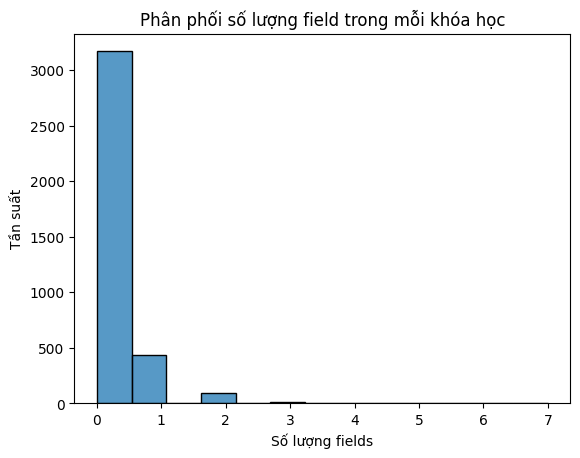

In [ ]:
sns.histplot(count_course_field_df, x='count_field')
plt.title('Phân phối số lượng field trong mỗi khóa học')
plt.xlabel('Số lượng fields')
plt.ylabel('Tần suất')

In [ ]:
count_course_field_df.describe()

,count_field
count,3716.000000
mean,0.183800
std,0.494237
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000


Từ biểu đồ và bảng thống kê ta thấy có rất nhiều khóa học không có field nào.

Thống kê số lượng khóa học theo từng field

In [ ]:
count_field_course = course_field_filtered['field'].value_counts().reset_index()
count_field_course

,field,count
0,计算机科学与技术,63
1,艺术学,35
2,外国语言文学,34
3,数学,21
4,历史学,20
...,...,...
76,海洋科学,1
77,船舶与海洋工程,1
78,军队指挥学,1
79,冶金工程,1


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80],
 [Text(0, 0, '计算机科学与技术'),
  Text(1, 0, '艺术学'),
  Text(2, 0, '外国语言文学'),
  Text(3, 0, '数学'),
  Text(4, 0, '历史学'),
  Text(5, 0, '物理学'),
  Text(6, 0, '管理科学与工程'),
  Text(7, 0, '中国语言文学'),
  Text(8, 0, '应用经济学'),
  Text(9, 0, '临床医学'),
  Text(10, 0, '工商管理'),
  Text(11, 0, '生物学'),
  Text(12, 0, '心理学'),
  Text(13, 0, '体育学'),
  Text(14, 0, '政治学'),
  Text(15, 0, '化学工程与技术'),
  Text(16, 0, '电子科学与技术'),
  Text(17, 0, '教育学'),
  Text(18, 0, '环境科学与工程'),
  Text(19, 0, '基础医学'),
  Text(20, 0, '哲学'),
  Text(21, 0, '控制科学与工程'),
  Text(22, 0, '

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E

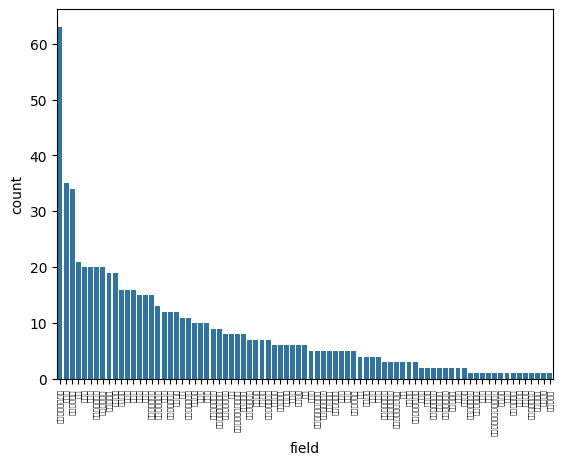

In [ ]:
sns.barplot(count_field_course, x='field', y='count')
plt.xticks(rotation=90, fontsize=5)

In [ ]:
count_field_course.describe()

,count
count,81.000000
mean,8.432099
std,9.443170
min,1.000000
25%,2.000000
50%,6.000000
75%,11.000000
max,63.000000


## **school**

In [ ]:
school_df = load_file_json('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/entities/school.json')
school_df

429it [00:00, 669.62it/s]


,id,name,name_en,sign,about,motto
0,S_1,清华大学,Tsinghua University,thu,简称“清华”，由中华人民共和国教育部直属，中央直管副部级建制，位列“211工程”、“985工...,"自强不息,厚德载物"
1,S_2,北京大学,Peking University,PKU,北京大学（Peking University），简称“北大”，是中华人民共和国教育部直属的全...,博学、审问、慎思、明辨
2,S_3,武汉大学,Wuhan University,whu,武汉大学（Wuhan University）简称“武大”，是中华人民共和国教育部直属的综合性...,自强 弘毅 求是 拓新
3,S_4,苏州大学,Soochow University,suda,苏州大学（Soochow University），坐落于历史文化名城苏州，是教育部与江苏省人...,养天地正气，法古今完人
4,S_5,四川大学,Sichuan University,scu,四川大学（Sichuan University），简称“川大”，坐落于四川省会成都，是教育部...,
...,...,...,...,...,...,...
424,S_1402,高雄医学大学,Kaohsiung Medical University,Kaohsiung Medical University,高雄医学大学（Kaohsiung Medical University）源自1954年创校的...,
425,S_1405,黑龙江农垦职业学院,Heilongjiang Agricultural ReclamationVocationa...,nkzy,黑龙江农垦职业学院（Heilongjiang Agricultural Reclamatio...,
426,S_1448,江西财经大学,Jiangxi University of Finance And Economics,jxufe,江西财经大学（Jiangxi University of Finance and Econo...,
427,S_1453,贵州交通职业技术学院,GuiZhou Communications Polytechnic,gzjtzy,贵州交通职业技术学院是一所以交通为特色的理工类高职院校。创办于1958年，走过国家“示范校”...,知行合一 德技双馨


In [ ]:
school_df.describe()

,id,name,name_en,sign,about,motto
count,429,429,429,429,429,429
unique,429,422,424,421,421,140
top,S_1,长安大学,Dalian University of Technology,hzic,消防高等专科学校，加挂应急管理部消防救援局昆明训练总队牌子，是应急管理部消防救援局直属的一所...,
freq,1,2,2,2,2,282


In [ ]:
school_df.shape[0]

429

In [ ]:
check_na(school_df)

,0
id,0
name,0
name_en,0
sign,0
about,0
motto,282


In [ ]:
course_school_df = pd.read_csv('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/relations/course-school.txt', sep='\t', header=None, names=['course', 'school'])

In [ ]:
course_school_df.describe()

,course,school
count,3983,3983
unique,3951,494
top,C_681512,S_1
freq,2,551


In [ ]:
course_school_df.drop_duplicates(inplace=True)

Lọc những course và school hợp lệ, tức là xuất hiện trong hai file course.json và school.json

In [ ]:
valid_course = set(course_filtered['id'])
valid_school = set(school_df['id'])

In [ ]:
course_school_filtered = course_school_df[course_school_df['school'].isin(valid_school)]
course_school_filtered = course_school_filtered[course_school_filtered['course'].isin(valid_course)]

In [ ]:
course_school_filtered.describe()

,course,school
count,3604,3604
unique,3579,420
top,C_682258,S_1
freq,2,516


Lưu lại file course_school_filtered

In [ ]:
# Lưu DataFrame course_school_filtered thành file .txt với dấu phân cách là tab
course_school_filtered.to_csv('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/data_prepared/relations/course_school_filtered.txt',
                               index=False,
                               header=False,
                               sep='\t')

Thống kê số course của mỗi trường

In [ ]:
count_school_course = course_school_filtered['school'].value_counts()
count_school_course = pd.DataFrame(count_school_course)
count_school_course.reset_index(inplace=True)
count_school_course.columns = ['school', 'count_course']
count_school_course

,school,count_course
0,S_1,512
1,S_63,222
2,S_31,109
3,S_11,57
4,S_7,57
...,...,...
415,S_259,1
416,S_264,1
417,S_868,1
418,S_274,1


In [ ]:
count_school_course.describe()

,count_course
count,420.000000
mean,8.473810
std,28.554964
min,1.000000
25%,2.000000
50%,3.000000
75%,8.000000
max,512.000000


Text(0, 0.5, 'Tần suất')

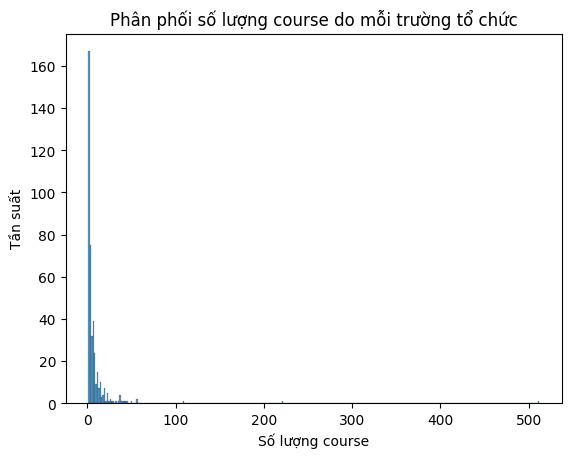

In [ ]:
sns.histplot(count_school_course, x='count_course')
plt.title('Phân phối số lượng course do mỗi trường tổ chức')
plt.xlabel('Số lượng course')
plt.ylabel('Tần suất')

Thống kê số trường cùng tổ chức course

In [ ]:
count_course_school = course_school_filtered['course'].value_counts()
count_course_school = pd.DataFrame(count_course_school)
count_course_school.reset_index(inplace=True)
count_course_school.columns = ['course', 'count_school']
count_course_school

,course,count_school
0,C_681058,2
1,C_680774,2
2,C_677218,2
3,C_680910,2
4,C_681509,2
...,...,...
3529,C_696986,1
3530,C_696987,1
3531,C_696988,1
3532,C_696989,1


In [ ]:
# Gộp các dòng theo course và tạo danh sách cho trường school
sc_agg = course_school_filtered.groupby('course')['school'].agg(list).reset_index()

# Đổi tên cột cho rõ ràng hơn (nếu cần)
sc_agg.rename(columns={'course': 'id', 'school': 'schools'}, inplace=True)

In [ ]:
sc_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579 entries, 0 to 3578
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3579 non-null   object
 1   schools  3579 non-null   object
dtypes: object(2)
memory usage: 56.0+ KB


Kết cột schools (sc_agg) vào course_filtered


In [ ]:
sc_agg

,id,schools
0,C_1017355,[S_33]
1,C_1017419,[S_52]
2,C_1025064,[S_13]
3,C_1025076,[S_72]
4,C_1025079,[S_97]
...,...,...
3529,C_955163,[S_1]
3530,C_956128,[S_144]
3531,C_956129,[S_492]
3532,C_956130,[S_11]


In [ ]:
course_filtered = pd.merge(course_filtered, sc_agg, left_on='id', right_on='id', how='left')


In [ ]:
course_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3716 non-null   object
 1   name           3716 non-null   object
 2   field          3716 non-null   object
 3   prerequisites  1200 non-null   object
 4   about          3716 non-null   object
 5   resource       3716 non-null   object
 6   schools        3534 non-null   object
dtypes: object(7)
memory usage: 203.3+ KB


In [ ]:
course_filtered[course_filtered['id'] == 'C_680764']

,id,name,field,prerequisites,about,resource,schools
2873,C_680764,信息隐藏技术,[],NaN,加密信息容易引起攻击者的注意并遭遇破译或破坏，而本课程讲授信息隐藏技术，以传输的存在性和信息...,"[{'titles': ['第一章 绪论', '1.1 信息隐藏技术的概念', '1.1 信...","[S_112, S_286]"


## concept

In [ ]:
concept_df = load_file_json('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/entities/concept.json')

637572it [00:19, 32066.40it/s]


In [ ]:
concept_df

,id,name,context
0,K_神经部_组织学与胚胎学,神经部,[]
1,K_促甲状腺激素细胞_组织学与胚胎学,促甲状腺激素细胞,[质和髓质两部分组成\n答案：B\n13．腺垂体嗜酸性细胞可分为\nA．催乳激素细胞、促肾上...
2,K_嗜色细胞_组织学与胚胎学,嗜色细胞,[]
3,K_生长激素细胞_组织学与胚胎学,生长激素细胞,[案：B\n13．腺垂体嗜酸性细胞可分为\nA．催乳激素细胞、促肾上腺皮质激素细胞和促甲状腺...
4,K_褐铁矿_材料科学与工程,褐铁矿,[\n褐铁矿（Limonite）是一种常见的铁矿，常形成于铁矿床的氧化带中，多以次生矿形态存...
...,...,...,...
637567,K_纤维结肠镜_食品科学与工程,纤维结肠镜,[]
637568,K_齐鲁工业大学_食品科学与工程,齐鲁工业大学,[]
637569,K_杞 _食品科学与工程,杞,[]
637570,K_转基因玉米_食品科学与工程,转基因玉米,[]


In [ ]:
concept_df.shape[0]

637572

In [ ]:
concept_df.isna().sum()

,0
id,0
name,0
context,0


In [ ]:
course_concept_df = pd.read_csv('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/relations/concept-course.txt', \
                                sep='\t', header=None, names=['concept', 'course'])


In [ ]:
course_concept_df

,concept,course
0,K_n号计数器_控制科学与工程,C_681460
1,K_串行链接_控制科学与工程,C_681460
2,K_热继电器按钮_控制科学与工程,C_681460
3,K_谐波污染_控制科学与工程,C_681460
4,K_偶校验转换_控制科学与工程,C_681460
...,...,...
451073,K_稳态人均资本_应用经济学,C_696675
451074,K_稳态的人均资本_应用经济学,C_696675
451075,K_资本的黄金律水平_应用经济学,C_696675
451076,K_折旧率_应用经济学,C_696675


In [ ]:
course_concept_df.describe()

,concept,course
count,451078,451078
unique,216096,887
top,K_行_计算机科学与技术,C_685689
freq,118,3515


Tương tự, lọc những course và concept hợp lệ

In [ ]:
valid_concept = set(concept_df['id'])
valid_course = set(course_df['id'])

In [ ]:
course_concept_filtered = course_concept_df[course_concept_df['course'].isin(valid_course)]
course_concept_filtered = course_concept_filtered[course_concept_filtered['concept'].isin(valid_concept)]

In [ ]:
course_concept_filtered.describe()

,concept,course
count,451078,451078
unique,216096,887
top,K_行_计算机科学与技术,C_685689
freq,118,3515


Thống kê số lượng concept của các course

In [ ]:
count_concept_course = course_concept_filtered['course'].value_counts().reset_index()
count_concept_course

,course,count
0,C_685689,3515
1,C_681743,3515
2,C_696683,3469
3,C_696855,2091
4,C_697379,2051
...,...,...
882,C_696794,1
883,C_799783,1
884,C_1764842,1
885,C_680927,1


In [ ]:
count_concept_course.describe()

,count
count,887.000000
mean,508.543405
std,454.520130
min,1.000000
25%,186.000000
50%,402.000000
75%,724.500000
max,3515.000000


Text(0, 0.5, 'Tần suất')

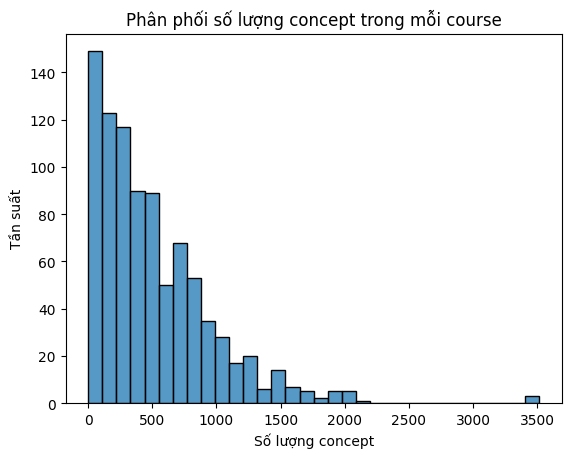

In [ ]:
sns.histplot(count_concept_course, x='count')
plt.title('Phân phối số lượng concept trong mỗi course')
plt.xlabel('Số lượng concept')
plt.ylabel('Tần suất')

In [ ]:
course_concept_filtered.to_csv(os.path.join(PRE_DATA_DIR, 'relations/course_concept_filtered.txt'), index=False,
                               header=False,
                               sep='\t')

## teacher

In [ ]:
teacher_df = load_file_json('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/entities/teacher.json')
teacher_df.head()

17018it [00:01, 11378.16it/s]


,id,name,name_en,about,job_title,org_name
0,T_1,刘燕妮,Yanni Liu,北大哲学系毕业，清华大学马克思主义学院讲师。开设过的课程，马克思主义哲学；马克思主义原理；儒...,讲师,清华大学
1,T_2,陈怡,Yi Chen,1945年生于重庆，1967年华中工学院（现华中科技大学）发配电专业本科毕业，1982年南京...,教授,清华大学
2,T_3,程钢,Gang Cheng,程钢，《庄子哲学导读》课程负责人，清华大学历史系副教授，清华大学国家大学生文化素质教育基地副主任。,副教授,清华大学
3,T_4,谢维和,None,谢维和，博士、教授、博士生导师、教育研究院院长。研究方向：教育学原理、教育社会学、高等教育和...,教授,清华大学
4,T_5,史静寰,Jing-huan Shi,史静寰，女，清华大学教育研究院教授、博士生导师、清华大学第12届学位评定委员会副主席、教育学...,教授,清华大学


In [ ]:
check_na(teacher_df)

,0
id,0
name,0
name_en,11635
about,3125
job_title,2250
org_name,0


In [ ]:
course_teacher_df = pd.read_csv('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/raw/relations/course-teacher.txt', \
                                sep='\t', header=None, names=['course', 'teacher'])

In [ ]:
course_teacher_df.describe()

,course,teacher
count,97192,97192
unique,13866,12252
top,C_762789,T_82
freq,648,336


In [ ]:
# Đếm số dòng trùng lặp
course_teacher_df.duplicated().sum()

51186

In [ ]:
course_teacher_df.drop_duplicates(inplace=True)

In [ ]:
course_teacher_df.info()

In [ ]:
valid_course = set(course_filtered['id'])
valid_teacher = set(teacher_df['id'])

course_teacher_filtered = course_teacher_df[course_teacher_df['teacher'].isin(valid_teacher)]
course_teacher_filtered = course_teacher_filtered[course_teacher_filtered['course'].isin(valid_course)]

In [ ]:
course_teacher_filtered

,course,teacher
80,C_584313,T_20
81,C_584329,T_21
82,C_584329,T_22
83,C_584381,T_23
93,C_597208,T_28
...,...,...
96132,C_2344479,T_16368
96133,C_2344479,T_16369
96134,C_2344479,T_16370
96135,C_2344479,T_16371


In [ ]:
course_teacher_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35512 entries, 80 to 96136
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   course   35512 non-null  object
 1   teacher  35512 non-null  object
dtypes: object(2)
memory usage: 832.3+ KB


Thống kê số lượng course của mỗi teacher

In [ ]:
count_teacher_course = course_teacher_filtered['teacher'].value_counts()
count_teacher_course = pd.DataFrame(count_teacher_course)
count_teacher_course.reset_index(inplace=True)
count_teacher_course.columns = ['teacher id', 'count_course']
count_teacher_course

,teacher id,count_course
0,T_805,46
1,T_38,41
2,T_540,40
3,T_28,39
4,T_43,39
...,...,...
9825,T_12882,1
9826,T_12880,1
9827,T_12921,1
9828,T_12919,1


In [ ]:
count_teacher_course.describe()

,count_course
count,9830.000000
mean,3.612614
std,2.314627
min,1.000000
25%,2.000000
50%,4.000000
75%,4.000000
max,46.000000


Text(0, 0.5, 'Tần suất')

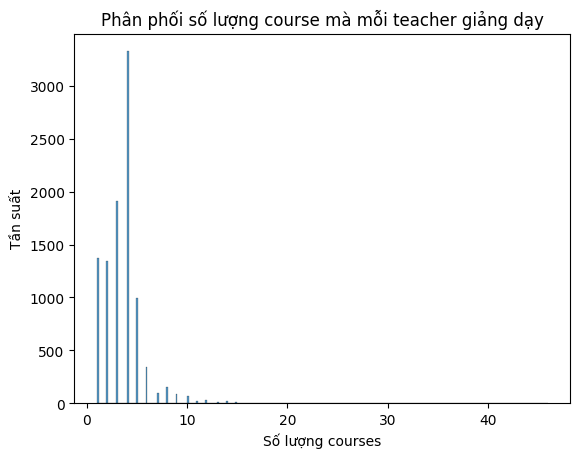

In [ ]:
sns.histplot(count_teacher_course, x='count_course')
plt.title('Phân phối số lượng course mà mỗi teacher giảng dạy')
plt.xlabel('Số lượng courses')
plt.ylabel('Tần suất')

Tiếp tục, thống kê số teacher dạy cho 1 khoá học

In [ ]:
count_course_teacher = course_teacher_filtered['course'].value_counts()
count_course_teacher = pd.DataFrame(count_course_teacher)
count_course_teacher.reset_index(inplace=True)
count_course_teacher.columns = ['course id', 'count_teacher']
count_course_teacher

,course id,count_teacher
0,C_681031,216
1,C_769301,196
2,C_734024,98
3,C_707063,80
4,C_911733,78
...,...,...
3637,C_1902586,1
3638,C_696575,1
3639,C_1906186,1
3640,C_1906203,1


In [ ]:
count_course_teacher.describe()

,count_teacher
count,3642.000000
mean,9.750686
std,11.411357
min,1.000000
25%,3.000000
50%,5.000000
75%,12.000000
max,216.000000


Text(0, 0.5, 'Tần suất')

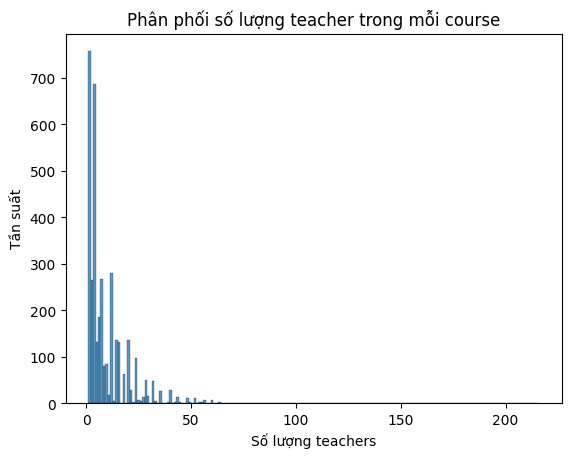

In [ ]:
sns.histplot(count_course_teacher, x='count_teacher')
plt.title('Phân phối số lượng teacher trong mỗi course')
plt.xlabel('Số lượng teachers')
plt.ylabel('Tần suất')

Lưu lại course_teacher_filtered

In [ ]:
course_teacher_filtered.to_csv('/content/drive/MyDrive/HK5/Mạng xã hội/Nhom12/Data/data_prepared/relations/course_teacher_filtered.txt',
                               index=False,
                               header=False,
                               sep='\t')

Tạm thời kết cột teacher vào bảng course

In [ ]:
# Gộp các dòng theo course và tạo danh sách teacher
ct_agg = course_teacher_filtered.groupby('course')['teacher'].agg(list).reset_index()

# Đổi tên cột cho rõ ràng hơn (nếu cần)
ct_agg.rename(columns={'course': 'id', 'teacher': 'teachers'}, inplace=True)

In [ ]:
ct_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3671 entries, 0 to 3670
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3671 non-null   object
 1   teachers  3671 non-null   object
dtypes: object(2)
memory usage: 57.5+ KB


In [ ]:
course_filtered = pd.merge(course_filtered, ct_agg, left_on='id', right_on='id', how='left')
course_filtered.head()

,id,name,field,prerequisites,about,resource,schools,teachers
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso...",[S_1],[T_20]
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':...",[S_1],"[T_21, T_22]"
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res...",[S_1],[T_23]
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide...",[S_1],[T_28]
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],...",[S_6],"[T_41, T_42]"


In [ ]:
course_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3779 non-null   object
 1   name           3779 non-null   object
 2   field          3779 non-null   object
 3   prerequisites  3779 non-null   object
 4   about          3779 non-null   object
 5   resource       3779 non-null   object
 6   schools        3579 non-null   object
 7   teachers       3671 non-null   object
dtypes: object(8)
memory usage: 236.3+ KB


In [ ]:
course_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3716 non-null   object
 1   name           3716 non-null   object
 2   prerequisites  1200 non-null   object
 3   about          3716 non-null   object
 4   resource       3716 non-null   object
 5   field          547 non-null    object
 6   schools        3534 non-null   object
 7   teachers       3642 non-null   object
dtypes: object(8)
memory usage: 232.4+ KB


## **Phân cụm topic cho course dựa trên name**

In [ ]:
!pip install bertopic

In [ ]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

multilingual_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
topic_model = BERTopic(embedding_model=multilingual_model)

# Phân tích topic
topics, probs = topic_model.fit_transform(course_filtered["name"])

# Thêm cột "topic" vào DataFrame
course_filtered["topic"] = topics

course_filtered.head()

In [ ]:
topic_model.get_topic_info()

## Course-topic

Lọc ra các quan hệ course-topic mà topic khác -1, do topic bằng -1 là các giá trị ngoại lai

In [ ]:
course_topic = course_filtered[course_filtered['topic'] != -1][['id', 'topic']]

In [ ]:
course_topic.to_csv('/content/drive/MyDrive/Mạng xã hội/FM/course_topic.txt', index=False,
                                                                              header=False,
                                                                              sep='\t')

## **Lưu bảng course filtered**

In [ ]:
course_filtered.to_json(os.path.join(PRE_DATA_DIR,'entities/course_prepared.json'),
                                orient='records',
                                lines=True)

In [ ]:
check_na(course_filtered)

,0
id,0
name,0
field,0
prerequisites,2423
about,0
resource,0
schools,0
teachers,0


drop bỏ cột prerequisites

In [ ]:
course_filtered = course_filtered.drop(columns=['prerequisites'])

In [ ]:
course_filtered.head()

,id,name,field,about,resource,schools,teachers
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso...",[S_1],[T_20]
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':...",[S_1],"[T_21, T_22]"
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res...",[S_1],[T_23]
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide...",[S_1],[T_28]
4,C_597225,大学计算机,[],大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],...",[S_6],"[T_41, T_42]"
